# Hubble Law Part 3: Extracting the Hubble Constant 
Author: Dylan Linthorne

## Objective: 
---

n part 1 of the lab we calculated the radial velocities of galaxies receding from our line of sight using the redshift of the hydrogen alpha line. Whereas in part 2 we filled in the games of the missing distances to these galaxies by measuring its angular size and taking advantage of the average size of a spiral galaxy. The Hubble Law can now be investigated using the galactic information acquired. In the end of this notebook you'll be in a position to quote a final measured Hubble constant from applying regression models onto the data, as well as, goodness-of-fit statistics and comparisons. These final results will include:

* Hubble Constant: $H_{o} \pm \sigma_{H}$.
* Residuals of the regression.
* Goodness-of-fit: $\chi^2$, degrees of freedom, p-value.
* Comparison: Student T-test using literature values.

In [64]:
import pandas as pd            #for our data structuress
import numpy as np             #for manipulating data
import matplotlib as mpl       #for visualization
import scipy.optimize as sp             #for chi2 model fitting/minimization
from scipy.stats import chi2

### Read in $(V_{radial}, D_{galactic})$:

Read in te distances from the file distances.txt and velocities from radial_vel.txt into arrays. Both files should be ordered in the same manner (in increasing NGC galaxy designation).

In [5]:
dis_data = np.loadtxt(str(directory) + "distances.txt");
vel_data = np.loadtxt(str(directory) + "radial_vel.txt");

distances = dis_data[:,1];
velocities = vel_data[:,0];
velocities_std = vel_data[:,1];

Visualize the data with error bars to inspect for any possible correlation.

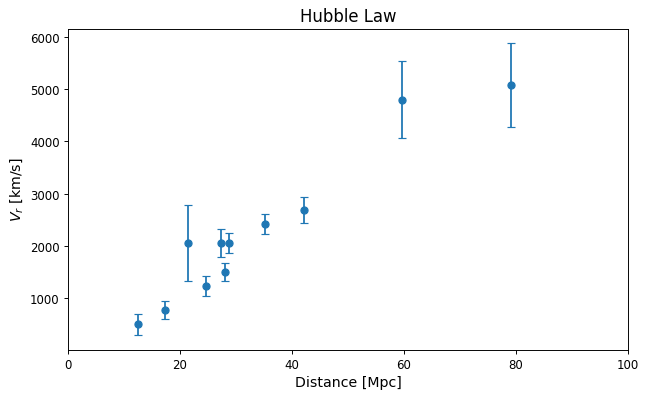

In [20]:
%matplotlib inline

fig, ax = mpl.pyplot.subplots(figsize=(8.5, 5), dpi=85);

ax.errorbar(distances, velocities, velocities_std, ls='none', marker ="o", capsize=3);
ax.set_xlim(0,100)
ax.set_title('Hubble Law', fontsize = 14);
ax.set_xlabel('Distance [Mpc]', fontsize = 12);
ax.set_ylabel('$V_{r}$ [km/s]', fontsize = 12);


## Linear Regression:


Hubble's Law is a linear relation, meaning, we can take advantage of MATLAB's $\chi^2 $-fitting and linear regression methods. Similar to how we fit a Gaussian to the spectral lines, we'll additionally feed it the algorithm an additional parameter, the 'weight'. The weight is defined as $w = 1/\sigma^2$. We'll be using the two parameter linear function poly1 as our fit model. Which is defined as, 

$$ v(d| p_1,p_2) = p_{1} \cdot d + p_{2} $$

Where $v$ is the radial velocity in km/s, $d$ is the galactic distance in Mpc, and the $p_1$ is the estimated Hubble Constant $H_o$.


In [21]:
def poly1(x, p1, p2):
    return p1*x + p2

In [22]:
coeff, var_matrix = sp.curve_fit(poly1, distances, velocities, sigma = velocities_std)

In [27]:
print("shape of coefficents: " + str(coeff.shape))
print("shape of covariance matrix: " + str(var_matrix.shape))
print("p1: " + str(coeff[0]) + " km/s/Mpc")
print("p2: " + str(coeff[1]) + " km/s")

shape of coefficents: (2,)
shape of covariance matrix: (2, 2)
p1: 79.76900247959824 km/s/Mpc
p2: -514.6687441060325 km/s


Similar to part 1, created a linear function from the parameter's estimated from the regression. Create an array of linearly spaced distance values which is used to construct the final function. Plot this on top of our data. How does it look visually?

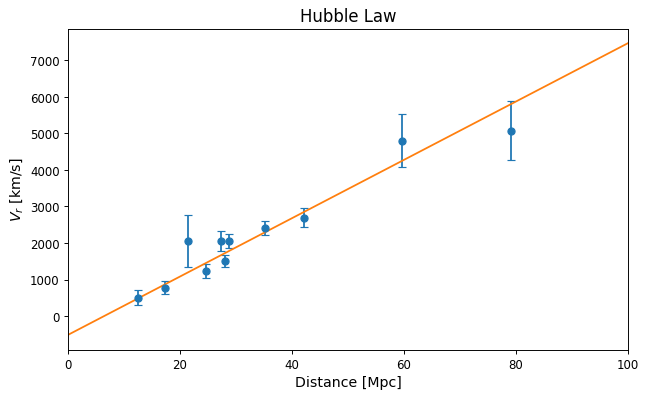

In [30]:
x_dis = np.linspace(0,100,100);
ax.plot(x_dis, poly1(x_dis, coeff[0], coeff[1]))
fig

## Error Analysis, Goodness-of-fit, and P-value:


To extract the estimated errors on the parameters, use the Jocobian matrix from our fit. Finding the errors on the parameters requires a bit of extra statistics and some linear algebra. Within the fit_ouput object matlab calculates the weighted Jocobian matrix $J$. This mathematical object facilates the transformations of our parameter coordinate system into the new minimized system (you don't have to worry about understanding the gritty details if this is outside the scope of your statistics knowlegde). We care about this object because it allows us to calculate the covariance matrix $\epsilon_{ij}$, which encodes the various uncertainties of our parameters. The covariance is defined as, 

$$\epsilon_{ij} = \frac{1}{2}\bigg(\frac{\partial \chi}{\partial a_{i} \partial a_{j}}\bigg)^{-1}  = (J^{T}J)^{-1}$$

The last line is the inverse of the product of the jocobian matrix with it's transpose. Keeping in mind that the diagonals on the covariance matrix equal the variance on the parameters $Var[p_{i}]$, in order $i = (1,2)$. 

In [39]:
pd.DataFrame(var_matrix, columns = ["$\sigma_{p1}$", "$\sigma_{p2}$"], index=["$\sigma_{p1}$", "$\sigma_{p2}$"])

,$\sigma_{p1}$,$\sigma_{p2}$
$\sigma_{p1}$,58.543850,-1560.159585
$\sigma_{p2}$,-1560.159585,47362.992657


#### Quote the estimated Hubble Constant :

In [44]:
hubble_const = coeff[0]
print("Estimated Hubble Constant: " +str(hubble_const) + " km/s/Mpc")

Estimated Hubble Constant: 79.76900247959824 km/s/Mpc


#### Quote the estimated error :

In [45]:
hubble_const_std = np.sqrt(var_matrix[0][0])
print("Estimated Standard Dev: " +str(hubble_const_std) + " km/s/Mpc")

Estimated Standard Dev: 7.651395311717503 km/s/Mpc


Ideally we want to ask: "what is the probability, if our hypothesis is correct, of getting a $\chi^2_{\text{min}}$ value greater than or equal to the one that we got?". The answer is the p-value, and is given by, 

$$p = \int^{\infty}_{\chi^2_{\text{min}}} f(x|\nu) dx$$

This basically represents the integral of the remaining (one sided) tail $f(x|\nu)$. We can check if our p-value less than some selected signifigance, usually taken to be 0.5 ($2\sigma$ signifigance). If p < 0.05, then we reject the hypothesis that our chosen model is the correct model. Otherwise, we fail to reject the hypothesis (that’s the strongest thing we can say; we are unable to conclude that the hypothesis is the correct one). But getting a large p-value (i.e. > 0.95) is also non-ideal. It means that we are overfitting the data (i.e. too many parameters in the fit model) or that our measurement uncertainties are overestimated. On average, we expect the p-value to be about 0.5 if the hypothesis is correct. Keep in mind it does not tell us wheather our hypothesis are right. We can only ask how likely it is to optain this value assuming it is sampled from a given hypothesis.

Alternatively, the chi-squared distribution has an expectation value of 𝜈, so if our calculated $\chi^2_{\text{min}}$ ≈ 𝜈, then we say the fit is ‘good’. Using this logic we it is customary to define $\chi^{2}_{\nu} =\chi^2/\nu $, the reduced chi-squared statistic. Based on the above, for a ‘good’ fit it should be about equal to 1. Typically it is more informative to report the p-value, the $\chi^2_{\text{min}}$ and 𝜈, rather than simply reporting the value of $\chi^{2}_{\nu}$.  

Having the final estimated value and associated error $H_{o} \pm \sigma_{H}$ isn't enough. To feel confident in these results we need test the goodness of the fit. Specifically, the minimum $\chi^2$, the number of degrees of freedom, and the p-value of the observation. Keeping in mind that a proper statistical inference needs all three of these pieces. A p-value alone doesn't convey enough information to make a proper statistical statement of the data.  

#### Quote the minimum $\chi^2$ value:


In [80]:
min_chi_2 = np.dot((velocities - poly1(distances, coeff[0], coeff[1]))**2,1/(velocities_std**2))
print("Minimum chi2 :" + str(min_chi_2))

Minimum chi2 :10.774898350038448


#### Quote the number of degrees of freedom $N_{data} - N_{parameters}$:


In [78]:
dof = len(distances) - 2
print("Degrees-of-freedom :" + str(dof))

Degrees-of-freedom :9


#### Last but not least, the p-value of getting  given the model:


In [79]:
p_value = (1 - chi2.cdf(min_chi_2, dof))
reduced_chi2 = min_chi_2/dof

print("Upper p-value :" + str(p_value))
print("Reduced chi2 :" + str(reduced_chi2))

Upper p-value :0.29145469340167807
Reduced chi2 :1.1972109277820497


## Student's T-test Comparison:


The Hubble's consant was estimated from a linear regression with levels of success and significance. Even if our test-statistics increased our confidence in our model we still need to compare our estimated value with that of other literature values. As mentioned in the introduction, there are many independent techniques of measuring the Hubble Constant. We'll compare our value with that of the PLANK Collaborations measurement using the Cosmic Microwave Background: $H_{0} = 67.4 \pm 0.5 \text{ km s}^{-1} \text{ Mpc}^{-1}$(https://doi.org/10.1051/0004-6361/201833910). The Student t-test statistic is a standard method of comparing two means (our measurment and literature value) and testing whether they are sampled from the same distribution. The null hypothesis is that our two values are sampled from the same physical process, or distribution using,

$$ t = \frac{|H^{f} - H^{CMB}|}{\sqrt{\sigma_{H,f}^2 + \sigma_{H,CMB}^2 }}$$

Where $t < 2$ is consistent with our null hypothesis (they are consistent within 95% CL), and $t > 2$ is inconsistent with our null hypothesis. 

In [77]:
hubble_const_cmb = 67.4;
hubble_const_cmb_std = 0.5;

t = np.divide(np.abs((hubble_const_cmb)-(hubble_const)),np.sqrt((hubble_const_cmb_std)**2 + (hubble_const_std)**2))
print("Student's t-test :" + str(t))

Student's t-test :1.6131276144480378


### Questions:


#### 1) Given our model and its estimated fit parameters, what can we say about the hubble law relation? (are they the same?)

#### 2) If the t-test showed the two values to be inconsistent, give some sources of systematic errors that might have caused the discrepancy? If they where consistent, is this enough to trust this value as the correct Hubble Constant?